# Optimal PHEV Energy Management via Dynamic Programming
---
## Summary
This project utilizes dynamic programming with application to energy management in plug-in hybrid electric vehicles (PHEVs). The purpose of this is to build a "cycle beater" that will optimize for the Urban Dynamic Driving Schedule (UDDS) power demand. In other words, the "cycle beater" will optimially discharge the electric battery to minimize fuel consumption and maximize the vehicles's miles-per-gallon. Since UDDS is used for vehicle emissions testing by the EPA, it is illegal for car manufacturers to use such a technique to schedule battery use. That being said, manufacturers have been caught doing so. This was completed as part of a class project in my MS program. Thanks to Prof. Scott Moura for providing UDDS data and overall framework on this. 

## Key questions explored
- When is it optimal to use the battery instead of gasoline?
- How does the battery's initial state of charge (SOC) affect cumulative fuel consumption and final SOC?

## Techniques used
- dynamic programming
- control systems

## Key findings
- As I decrease the initial SOC, total fuel consumption increases. This makes sense because we have less energy stored in the battery and thus have to rely more on our engine to meet the power demand. Also, a lower initial SOC means that I have to charge our battery more throughout the ride. Charging the battery means that I have to utilize our engine to meet demand.
- The results also show that the initial and final SOC are linked. The higher the initial SOC, the higher the final SOC. Batteries that have an initial SOC under 0.60 have the same final SOC (0.268), which is near the minimum possible level. This makes sense because the batteries can “freely” utilize its stored energy without exceeding the maximum allowable battery power. In the case where initial SOC is higher (e.g. 0.9), battery power appears to be more constrained by its upper bound, $P_{batt, max}$. 
- Interestingly, final SOC and total fuel consumption for starting SOC of 0.9 and 0.75 are nearly identical.

![Results for SOC_0 = 0.75](results_all.png)

## Table of Contents

> ### Part 1. [Formulate problem](#formulate_optimization)
> ### Part 2. [Set parameters and extract data](#set_parameters)
> ### Part 3. [Gather intuition for the data](#gather_intuition)
> ### Part 4. [Define grid for state space](#grid)
> ### Part 5. [Solve dynamic program](#solve)
> ### Part 6. [Simulate optimal energy management results](#simulate)
> ### Part 7. [Plot simulation results for SOC_0 = 0.75](#plot_SOC75)
> ### Part 8. [Compare results for all initial SOC values](#plot_all)

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import interp
import timeit

fs = 13 # font size for plots

---

<a id="formulate_optimization"></a>
### Part 1: Formulate problem
Disclaimer: To understand this section, the reader should have a general understanding of optimization, dynamic programming, and circuits. 

#### 1.1 Formulate optimization problem

\begin{equation}
    \begin{aligned}
        \min \quad  & J= \sum\limits_{k=0}^{N-1} \alpha\Delta t P_{fuel}(k) \quad 
                    &&& \text{objective function} \\[5pt]
        \textrm{s.t.} \quad 
            & SOC(k+1) = SOC(k) - \dfrac{\Delta t}{Q_{cap}V_{oc}} P_{batt}(k), \quad \forall \ k = 0, ..., N-1
                    &&& \text{battery SOC dynamics} \\[5pt]
            & SOC_{min} \leq SOC(k) \leq SOC_{max}, \quad \forall \ k = 0, ..., N
                    &&& \text{battery charge must remain within set bounds} \\[5pt]
            & -P_{batt}^{max} \leq P_{batt}(k) \leq P_{batt}^{max}, \quad \forall \ k = 0, ..., N
                    &&& \text{battery power exchange limits} \\[5pt]
            & 0 \leq \ P_{dem}(k) - P_{batt}(k) \leq P_{eng}^{max}, \quad \forall \ k = 0, ..., N
                    &&& \text{engine power exchange limits} \\[10pt]
    \end{aligned}
\end{equation}

To assist with writing the code, _I will re-write the three inequalities as upper/lower limits on $P_{batt}(k)$_. For the purposes of this notebook, I haven't included the algebra required to do so.

$ \hspace{25mm} \dfrac{(SOC^{max} - SOC(k))Q_{cap}V_{oc}}{- \Delta t} \leq P_{batt}(k) \leq 
\dfrac{(SOC^{min} - SOC(k)) Q_{cap}V_{oc}}{- \Delta t}, \quad \forall \ k = 0, ..., N $

$ \hspace{25mm} -P_{batt}^{max} \leq P_{batt}(k) \leq P_{batt}^{max}, \quad \forall \ k = 0, ..., N $

$ \hspace{25mm} -P_{dem}(k) - P_{eng}^{max}  \leq P_{batt}(k) \leq P_{dem}(k), \quad \forall \ k = 0, ..., N $

By writing it in this format, _I can collapse these constraints into a single constraint,_ which will greatly assist the coding of the principle of optimality. 

$ \hspace{25mm} \max \bigg\{ \dfrac{(SOC^{max} - SOC(k))Q_{cap}V_{oc}}{- \Delta t}, -P_{batt}^{max}, -P_{dem}(k) \bigg\}
                                \leq P_{batt}(k) \leq 
                \min \bigg\{ \dfrac{(SOC^{min} - SOC(k)) Q_{cap}V_{oc}}{- \Delta t}, P_{batt}^{max}, P_{dem}(k) \bigg\} $


#### 1.2 Identify control variable and state variable
- control variable ($u_k$) is $P_{batt}(k)$, where positive values correspond to discharge.
- state variable ($x_k$) is $SOC(k)$.

#### 1.3 Define an appropriate value function
Let $V_k(x_k)$ denote the minimum cost-to-go from time-step $k$ to $N$, given the current battery state-of-charge $x_k = SOC(k)$ and the "cost-to-go" is define by fuel consumption.

#### 1.4 Define Principle of Optimality (Bellman equation)
\begin{equation}
    \begin{aligned}
        V_k(x_k) & = \min_{u_k} \Big\{ g_k(x_k, u_k) + V_{k+1}(x_{k+1}) \Big\} \\[5pt]
                 & = \min_{u_k} \Big\{ \alpha \Delta t P_{fuel}(k) + V_{k+1}(x_{k+1}) \Big\} \\[5pt]
                 & = \min_{u_k} \bigg\{ \alpha \Delta t \dfrac{P_{dem}(k) - 
                     P_{batt}(k)}{\eta (P_{dem}(k) - P_{batt}(k))} + V_{k+1}(x_{k+1}) \bigg\} \\[5pt]
     V_k(SOC(k)) & = \min_{P_{batt}(k)} \bigg\{ \alpha \Delta t \dfrac{P_{dem}(k) - 
                     P_{batt}(k)}{\eta (P_{dem}(k) - P_{batt}(k))} + V_{k+1}(SOC(k+1)) \bigg\} \\[10pt]
     \text{The boundary condition is:} \\[5pt]
                 \quad V_N(SOC(N))  & =  0
    \end{aligned}
\end{equation}

<a id="set_parameters"></a>

### Part 2. Set parameters and extract data
In this section, I set general parameters used in the DP. These can be adjusted freely here. Additionally, I load in the UDDS data.

In [2]:
# Time step
Delta_t = 1

# Fuel consumption in grams per unit energy
alph = 1e-4     # [g/(s-W)]

Qcap = 5*3600  # [A-s = Coulombs]
V_oc = 330     # [volts]

# Limits on Batt Power, Eng Power, SOC
P_batt_max = 15e3  # [W]
P_eng_max = 35e3   # [W]

SOC_min = 0.25     # [-]
SOC_max = 0.9      # [-]

# Load UDDS data
data = pd.read_csv("UDDS_Pdem.csv")
print(data.head())
print("\n\n")
print(data.describe())

t = np.asarray(data)[:,0]
P_dem = np.asarray(data)[:,1]*1e3
v_dc = np.asarray(data)[:,2]

   Time (sec), t  Pwr Demand (kW), P_dem  Velocity (m/s), v_dc  Unnamed: 3
0              0                     0.0                   0.0         NaN
1              1                     0.0                   0.0         NaN
2              2                     0.0                   0.0         NaN
3              3                     0.0                   0.0         NaN
4              4                     0.0                   0.0         NaN



       Time (sec), t  Pwr Demand (kW), P_dem  Velocity (m/s), v_dc  Unnamed: 3
count    1370.000000             1370.000000           1370.000000         0.0
mean      684.500000                1.642977              8.751999         NaN
std       395.629246                6.904154              6.569676         NaN
min         0.000000              -15.000000              0.000000         NaN
25%       342.250000               -0.246054              2.604008         NaN
50%       684.500000                1.077528              9.656064       

<a id="gather_intuition"></a>

### Part 3. Gather intuition for the data
I generated a couple of useful graphs to help me understand the data and the task at hand. This is by no means comprehensive, but is necessary for this particular project.

#### 3.1 Plot UDDS data
To get a better understanding of UDDS, I plot the data. In particular the UDDS contains sets two time-variant quantities: velocity (m/s) and power demand.

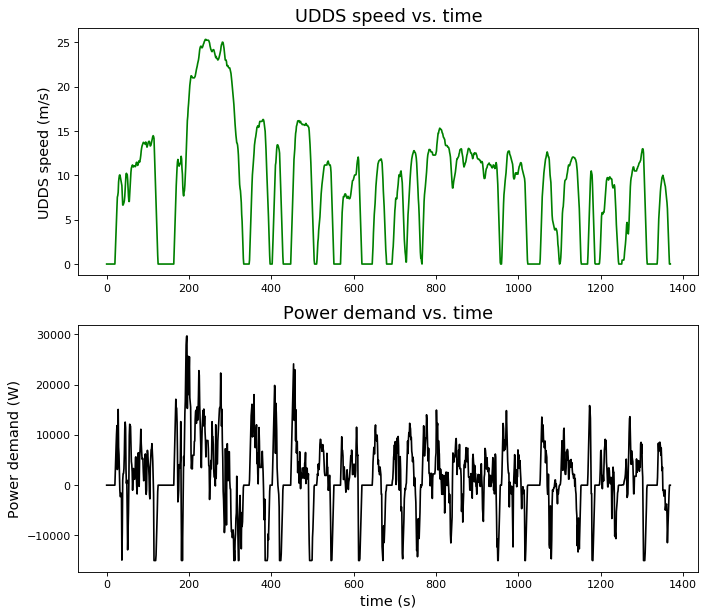

In [3]:
plt.figure(num=1, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
# Plot UDDS speed vs. time
plt.plot(t, v_dc, 'g')
plt.ylabel('UDDS speed (m/s)', fontsize=fs)
plt.title('UDDS speed vs. time', fontsize=16)

plt.subplot(2,1,2)
# Plot UDDS power demand vs. time
plt.plot(t, P_dem, 'k')
plt.xlabel('time (s)', fontsize=fs)
plt.ylabel('Power demand (W)', fontsize=fs)
plt.title('Power demand vs. time', fontsize=16)
plt.show()

#### 3.2 Engine efficiency
Ultimately, the goal of this project is to minimize fuel consumption. To solve this, it's important to understand how engine power affects fuel consumption. `eta_eng` is a function that calculates engine efficiency for a given power. I will use this later in the DP. To get basic intuition for efficiency, I plot power vs. efficiency.

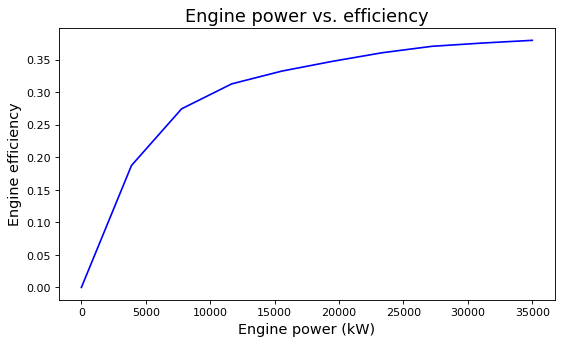

In [4]:
def eta_eng(P_eng):
    """
    Calculates engine efficiency for a given power.
    
    Keyword arguments: 
    power (float) -- power consumed by engine
    
    Returns: 
    efficiency (float) -- the engine's efficiency
        
    """
    # polynomial coefficients
    p1 =   5.128e-08
    p2 =  -5.927e-06
    p3 =   0.0002652
    p4 =    -0.00583
    p5 =      0.0672
    p6 =   2.622e-05

    # Convert from W to kW
    x = P_eng/1e3

    # Compute efficiency
    efficiency = p1*x**5 + p2*x**4 + p3*x**3 + p4*x**2 + p5*x + p6
    return efficiency

# powers to test
P_eng = np.linspace(0, P_eng_max, 10)

# plot efficiency versus engine power, for total range of engine powers
plt.figure(num=2, figsize=(8, 4.5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(P_eng, eta_eng(P_eng), 'b') 
plt.xlabel('Engine power (kW)', fontsize=fs)
plt.ylabel('Engine efficiency', fontsize=fs)
plt.title('Engine power vs. efficiency', fontsize=16)
plt.show()

<a id="grid"></a>

### Part 4. Define grid for state space
As part of the DP, I must convert the equations from continuous to discrete space. I (arbitrarily) decide there are 72 possible states for the battery charge. I also must preallocate the value function `V` and optimal controller `u_star`. 

In [5]:
SOC_grid = np.linspace(SOC_min,SOC_max,72)

# Grid size
ns = len(SOC_grid)  # No. of states

# Planning horizon (time steps)
N = len(t)

# Preallocate Value Function (rows index state, columns index time)
V = np.inf*np.ones((ns,N+1))

# Preallocate Control (rows index state, columns index time)
u_star = np.zeros((ns,N))

<a id="solve"></a>

### Part 5. Solve dynamic program
This is where the magic happens. Below I formulate the DP and determine the optimal control `u_star` for each state in `SOC_grid`. A key part of this is the `interp` function that allows me to manage the size of the state space. Note that `V_nxt` must be interpolated because `V` is defined on the `SOC_grid` and `SOC_nxt` will never fall exactly on a grid point. Therefore, we interpolate between grid points to find `V_nxt`.

In [6]:
# Boundary Condition of Value Function (Principle of Optimality)
V[:, N] = 0

# Iterate backward in time
for k in range(N-1, 0, -1):

    # Iterate over SOC
    for idx in range(0,ns):
        
        # Find dominant bounds for P_batt
        lb = max([(((SOC_max - SOC_grid[idx]) * Qcap * V_oc) / -Delta_t), -P_batt_max, P_dem[k] - P_eng_max])
        ub = min([(((SOC_min - SOC_grid[idx]) * Qcap * V_oc) / -Delta_t), P_batt_max, P_dem[k]])
        
        # Grid Battery Power between dominant bounds
        P_batt_grid = np.linspace(lb, ub, 200)
        
        # Compute engine power (vectorized for all P_batt_grid)
        P_eng = P_dem[k] - P_batt_grid
        
        # Cost-per-time-step, a.k.a. fuel consumed at each stage (vectorized for all P_batt_grid)
        g_k = (Delta_t * alph * P_eng) / (eta_eng(P_eng))
        
        # compute next SOC using dynamics
        SOC_nxt = SOC_grid[idx] - (Delta_t * P_batt_grid / (Qcap * V_oc))
        
        # Compute value function at nxt time step (need to interpolate)
        V_nxt = interp(SOC_nxt, SOC_grid, V[:,k+1])
        
        # Value Function (Principle of Optimality)
        V[idx,k] = min(g_k + V_nxt)
        ind = np.argmin(g_k + V_nxt)
        
        # Save Optimal Control
        u_star[idx,k] = P_batt_grid[ind]

<a id="simulate"></a>

### Step 6. Simulate optimal energy management results
Now that I've solved the DP, I can use the `u_star` "map" to optimize battery usage! I do this for five different starting battery charge (`SOC_0`) to understand its impact on fuel consumption and final charge. 

In [7]:
def optimize_PHEV(SOC_0):
    """
    Finds optimal engine/battery usage based on the initial battery SOC.
    
    Keyword arguments: 
    SOC_0 (float) -- initial battery SOC when running UDDS
    
    Returns: 
    P_batt_sim (ndarray) -- simulated/optimal power from battery at each time step
    P_eng_sim (ndarray) -- simulated/optimal power from engine at each time step
    J_sim (ndarray) -- simulated/optimal fuel consumption at each time step
    SOC_sim (ndarray) -- simulated/optimal battery SOC at each time step
    """
    # Preallocate
    SOC_sim = np.zeros(N)
    P_batt_sim = np.zeros(N)
    P_eng_sim = np.zeros(N)
    J_sim = np.zeros(N)

    # Initialize
    SOC_sim[0] = SOC_0

    # Simulate PHEV Dynamics
    for k in range(0,(N-1)):

        # Use optimal battery power, for given SOC
        P_batt_sim[k] = interp(SOC_sim[k], SOC_grid, u_star[:,k])

        # Compute engine power
        P_eng_sim[k] = P_dem[k] - P_batt_sim[k]

        # Fuel Consumption
        J_sim[k] = (Delta_t * alph * P_eng_sim[k]) / (eta_eng(P_eng_sim[k]));

        # Time-step SOC dynamics
        SOC_sim[k+1] = SOC_sim[k] - (Delta_t * P_batt_sim[k] / (Qcap * V_oc));
        
    return P_batt_sim, P_eng_sim, J_sim, SOC_sim

# Run for different SOC_0
P_batt_sim90, P_eng_sim90, J_sim90, SOC_sim90 = optimize_PHEV(SOC_0=0.90)
P_batt_sim75, P_eng_sim75, J_sim75, SOC_sim75 = optimize_PHEV(SOC_0=0.75)
P_batt_sim60, P_eng_sim60, J_sim60, SOC_sim60 = optimize_PHEV(SOC_0=0.60)
P_batt_sim45, P_eng_sim45, J_sim45, SOC_sim45 = optimize_PHEV(SOC_0=0.45)
P_batt_sim30, P_eng_sim30, J_sim30, SOC_sim30 = optimize_PHEV(SOC_0=0.30)

<a id="plot_SOC75"></a>

### Step 7. Plot simulation results for `SOC_0 = 0.75`
Now that I've solved the DP and simulated the UDDS, I visualize the results in the following plots for `SOC_0 = 0.75`, although any `SOC_0` could be used here. These graphs were selected because they are important to understanding the simulation. The first plot, which is also found above, shows how the required vehicle velocities for UDDS. The second plot shows the simulation results for how the battery discharges throughout the UDDS. The third plot indicates cumulative fuel consumption, while the fourth plot shows power output for both the engine and battery.

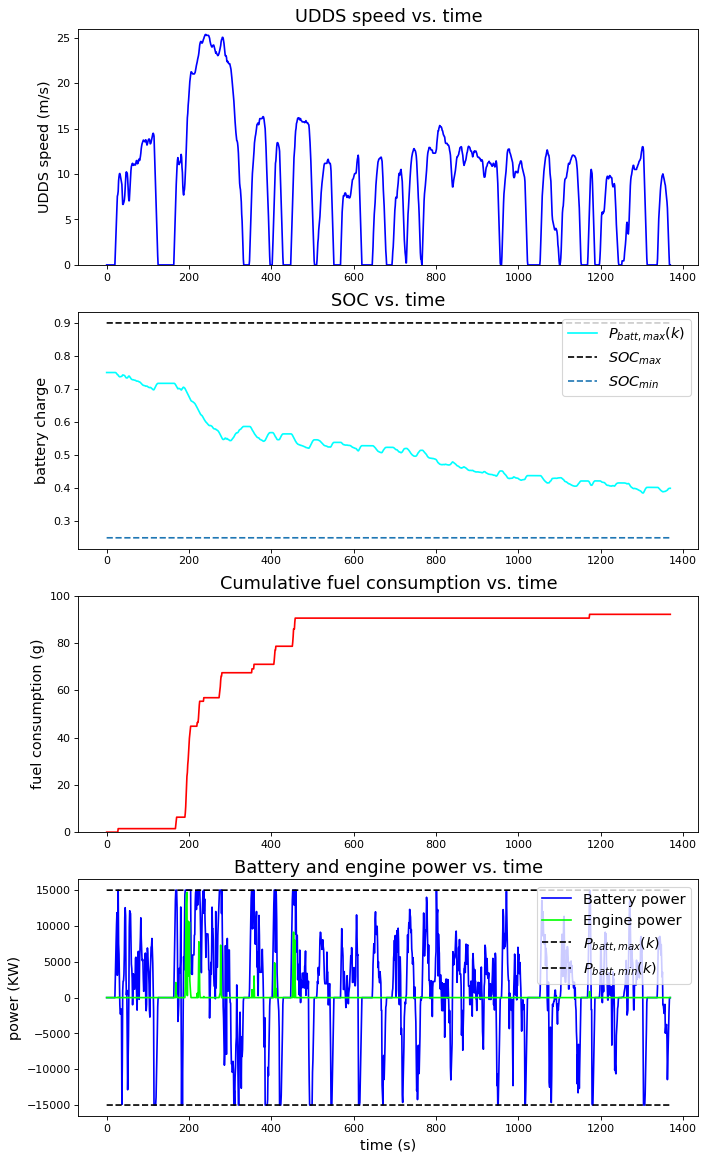

In [14]:
## Plot Simulation Results
plt.figure(num=4, figsize=(10, 18), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(4,1,1)
# UDDS speed versus time 
plt.plot(t, v_dc, 'b')
plt.ylabel('UDDS speed (m/s)', fontsize=fs)
plt.title('UDDS speed vs. time', fontsize=16)
plt.ylim([0,26])

plt.subplot(4,1,2)
# SOC versus time
plt.plot(t, SOC_sim75, 'aqua', label=r'$P_{batt,max}(k)$')
plt.plot(t, SOC_max*np.ones(t.shape), 'k--', label=r'$SOC_{max}$')
plt.plot(t, SOC_min*np.ones(t.shape), '--', label=r'$SOC_{min}$')
plt.ylabel('battery charge', fontsize=fs)
plt.title('SOC vs. time', fontsize=16)
plt.legend(loc=1, fontsize=fs)

plt.subplot(4,1,3)
# Accumulated fuel consumption [g] versus time
plt.plot(t, np.cumsum(J_sim75), 'r')
plt.ylabel('fuel consumption (g)', fontsize=fs)
plt.title('Cumulative fuel consumption vs. time', fontsize=16)
plt.ylim([0,100])

plt.subplot(4,1,4)
# Battery and engine power [kW] versus time
plt.plot(t, P_batt_sim75, 'blue', label='Battery power')
plt.plot(t, P_eng_sim75, 'lime', label='Engine power')
plt.plot(t, P_batt_max*np.ones(t.shape), 'k--', label=r'$P_{batt,max}(k)$')
plt.plot(t, -P_batt_max*np.ones(t.shape), 'k--', label=r'$P_{batt,min}(k)$')
plt.ylabel('power (KW)', fontsize=fs)
plt.title('Battery and engine power vs. time', fontsize=16)
plt.xlabel('time (s)', fontsize=fs)
plt.legend(loc=1, fontsize=fs)

plt.savefig('results_SOC75')

plt.show()

<a id="plot_all"></a>

### Step 8. Compare results for all initial SOC values
To solve my original question, I now create a table and charts showing the impact of `SOC_0` on fuel consumption and final $SOC$.

In [9]:
df = pd.DataFrame(columns=['Initial SOC', 'Final SOC', 'Total Fuel Cons. [g]'])
df['Initial SOC'] = [0.9, 0.75, 0.6, 0.45, 0.3]
df['Final SOC'] = [SOC_sim90[-1], SOC_sim75[-1], SOC_sim60[-1], SOC_sim45[-1], SOC_sim30[-1]]
df['Total Fuel Cons. [g]'] = [np.cumsum(J_sim90)[-1], 
                               np.cumsum(J_sim75)[-1], 
                               np.cumsum(J_sim60)[-1],
                               np.cumsum(J_sim45)[-1],
                               np.cumsum(J_sim30)[-1]]
df = df.set_index('Initial SOC')
df

,Final SOC,Total Fuel Cons. [g]
Initial SOC,,
0.90,0.549787,92.163983
0.75,0.399787,92.163983
0.60,0.268416,134.406810
0.45,0.268412,406.584139
0.30,0.268412,649.921055


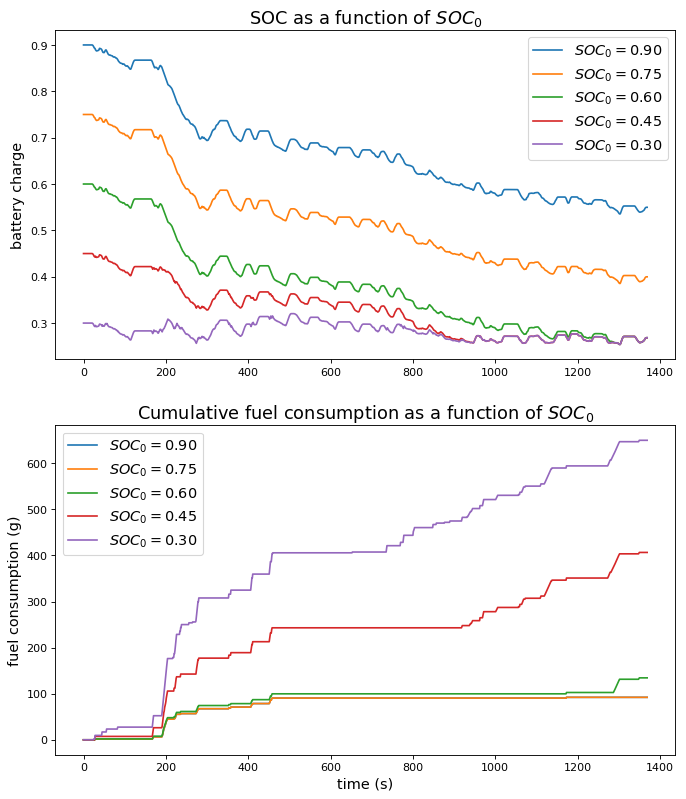

In [15]:
plt.figure(figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
# SOC versus time
plt.plot(t, SOC_sim90, label=r'$SOC_0 = 0.90$')
plt.plot(t, SOC_sim75, label=r'$SOC_0 = 0.75$')
plt.plot(t, SOC_sim60, label=r'$SOC_0 = 0.60$')
plt.plot(t, SOC_sim45, label=r'$SOC_0 = 0.45$')
plt.plot(t, SOC_sim30, label=r'$SOC_0 = 0.30$')
plt.ylabel('battery charge', fontsize=fs)
plt.title('SOC as a function of $SOC_0$', fontsize=16)
plt.legend(loc=1, fontsize=fs)

plt.subplot(2,1,2)
# Accumulated fuel consumption [g] versus time
plt.plot(t, np.cumsum(J_sim90), label=r'$SOC_0 = 0.90$')
plt.plot(t, np.cumsum(J_sim75), label=r'$SOC_0 = 0.75$')
plt.plot(t, np.cumsum(J_sim60), label=r'$SOC_0 = 0.60$')
plt.plot(t, np.cumsum(J_sim45), label=r'$SOC_0 = 0.45$')
plt.plot(t, np.cumsum(J_sim30), label=r'$SOC_0 = 0.30$')
plt.xlabel('time (s)', fontsize=fs)
plt.ylabel('fuel consumption (g)', fontsize=fs)
plt.title('Cumulative fuel consumption as a function of $SOC_0$', fontsize=16)
plt.legend(loc=0, fontsize=fs)

plt.savefig('results_all')
plt.show()